In [3]:
## import libraries and initialize spark session
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, desc, approx_count_distinct, countDistinct,log, sqrt
from pyspark.sql import functions as F

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import datetime
import plotly.figure_factory as ff
import plotly.offline as pyo

In [4]:
#initialize spark session
spark = SparkSession.builder \
    .appName("Data Exploration with PySpark") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/22 02:41:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
##Load Data
data_train = "./Datasets/train.csv"
data_testA = "./Datasets/testA.csv"

data_train = spark.read.csv(data_train, header=True, inferSchema=True)
data_testA = spark.read.csv(data_testA, header=True, inferSchema=True)

In [6]:
## Data Preprocessing

#check training dataset structure
data_train.printSchema()
data_train.show(5)

#check the size
print("Train data shape:",(data_train.count(),len(data_train.columns)))
print("TestA data shape:",(data_testA.count(),len(data_testA.columns)))

data_train.describe().show()

#check the NAN
data_train.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_train.columns]).show()

root
 |-- id: integer (nullable = true)
 |-- loanAmnt: double (nullable = true)
 |-- term: integer (nullable = true)
 |-- interestRate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- subGrade: string (nullable = true)
 |-- employmentTitle: double (nullable = true)
 |-- employmentLength: string (nullable = true)
 |-- homeOwnership: integer (nullable = true)
 |-- annualIncome: double (nullable = true)
 |-- verificationStatus: integer (nullable = true)
 |-- issueDate: string (nullable = true)
 |-- isDefault: integer (nullable = true)
 |-- purpose: integer (nullable = true)
 |-- postCode: double (nullable = true)
 |-- regionCode: integer (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinquency_2years: double (nullable = true)
 |-- ficoRangeLow: double (nullable = true)
 |-- ficoRangeHigh: double (nullable = true)
 |-- openAcc: double (nullable = true)
 |-- pubRec: double (nullable = true)
 |-- pubRecBankruptcies: d

24/05/22 02:41:42 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+----------+---------+-------+--------+----------+-----+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+------+----------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus| issueDate|isDefault|purpose|postCode|regionCode|  dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine| title|policyCode|  n0|  n1|  n2|  n3|  n4|  n5|  n6|  n7|  n8|  n9| n10| n11| n12| n13| n14|
+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+

Train data shape: (800000, 47)
TestA data shape: (200000, 46)


+-------+-----------------+-----------------+------------------+------------------+----------------+------+--------+------------------+----------------+------------------+-----------------+------------------+----------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+-------------------+------------------+------------------+----------------+------------------+------------------+-----------------+------------------+----------+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+--------------------+-------------------+------------------+
|summary|               id|         loanAmnt|              term|      interestRate|     installment| grade|subGrade|   employmentTitle|employmentLeng

+---+--------+----+------------+-----------+-----+--------+---------------+----------------+-------------+------------+------------------+---------+---------+-------+--------+----------+---+------------------+------------+-------------+-------+------+------------------+--------+---------+--------+-----------------+---------------+-----------------+-----+----------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| id|loanAmnt|term|interestRate|installment|grade|subGrade|employmentTitle|employmentLength|homeOwnership|annualIncome|verificationStatus|issueDate|isDefault|purpose|postCode|regionCode|dti|delinquency_2years|ficoRangeLow|ficoRangeHigh|openAcc|pubRec|pubRecBankruptcies|revolBal|revolUtil|totalAcc|initialListStatus|applicationType|earliesCreditLine|title|policyCode|   n0|   n1|   n2|   n3|   n4|   n5|   n6|   n7|   n8|   n9|  n10|  n11|  n12|  n13|  n14|
+---+--------+----+------------+-----------+-----+--------+---------------+---------

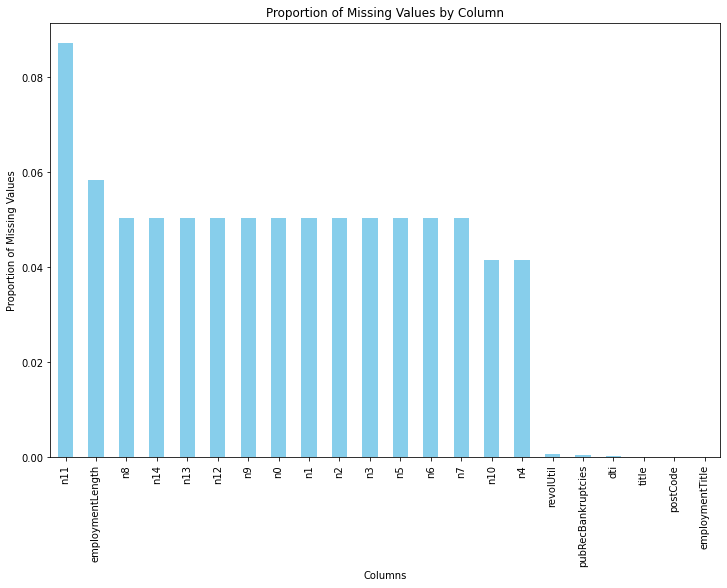

In [7]:
# visualize the NAN
# caclulate the missing ration
def calculate_missing_ratio(df):
    total_count = df.count()
    missing_ratio = df.select([((count(when(col(c).isNull(), c)) / total_count).alias(c)) for c in df.columns])
    return missing_ratio

# get the proportion of missing values
missing_ratio_df = calculate_missing_ratio(data_train)

# transform into pandas dataframe
missing_ratio_pd = missing_ratio_df.toPandas()
missing_ratio_pd = missing_ratio_pd.transpose()
missing_ratio_pd.columns = ['missing_ratio']
missing_ratio_pd = missing_ratio_pd[missing_ratio_pd['missing_ratio'] > 0]
missing_ratio_pd.sort_values(by='missing_ratio', ascending=False, inplace=True)

# plot a bar chart
plt.figure(figsize=(12, 8))
missing_ratio_pd['missing_ratio'].plot(kind='bar', color='skyblue')
plt.title('Proportion of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Proportion of Missing Values')
plt.show()

In [8]:
# Numeric and Object Type Characteristics
numeric_features = [t[0] for t in data_train.dtypes if t[1] == 'int' or t[1] == 'double']
object_features = [t[0] for t in data_train.dtypes if t[1] == 'string']

print("Numeric Features:", numeric_features)
print("Object Features:", object_features)

Numeric Features: ['id', 'loanAmnt', 'term', 'interestRate', 'installment', 'employmentTitle', 'homeOwnership', 'annualIncome', 'verificationStatus', 'isDefault', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'initialListStatus', 'applicationType', 'title', 'policyCode', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n11', 'n12', 'n13', 'n14']
Object Features: ['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']


In [9]:
data_train.select('grade').show(5)

+-----+
|grade|
+-----+
|    E|
|    D|
|    D|
|    A|
|    C|
+-----+
only showing top 5 rows



In [11]:
def get_numerical_serial_fea(data, feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    
    for fea in feas:
        unique_count = data.agg(approx_count_distinct(col(fea)).alias('distinct_count')).collect()[0]['distinct_count']
        
        if unique_count <= 10:
            numerical_noserial_fea.append(fea)
        else:
            numerical_serial_fea.append(fea)

    return numerical_serial_fea, numerical_noserial_fea

try:
    numerical_serial_fea, numerical_noserial_fea = get_numerical_serial_fea(data_train, numeric_features)
    print("Serial (Continuous) Numerical Features:", numerical_serial_fea)
    print("NoSerial (Discrete) Numerical Features:", numerical_noserial_fea)
except Exception as e:
    print("An error occurred:", e)

Serial (Continuous) Numerical Features: ['id', 'loanAmnt', 'interestRate', 'installment', 'employmentTitle', 'annualIncome', 'purpose', 'postCode', 'regionCode', 'dti', 'delinquency_2years', 'ficoRangeLow', 'ficoRangeHigh', 'openAcc', 'pubRec', 'pubRecBankruptcies', 'revolBal', 'revolUtil', 'totalAcc', 'title', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'n10', 'n13', 'n14']
NoSerial (Discrete) Numerical Features: ['term', 'homeOwnership', 'verificationStatus', 'isDefault', 'initialListStatus', 'applicationType', 'policyCode', 'n11', 'n12']


In [12]:
# count the value 
term_counts = data_train.groupBy("term").count()
term_counts.show()

homeOwnership_counts = data_train.groupBy("homeOwnership").count()
homeOwnership_counts.show()

verificationStatus_counts = data_train.groupBy("verificationStatus").count()
verificationStatus_counts.show()

initialListStatus_counts = data_train.groupBy("initialListStatus").count()
initialListStatus_counts.show()

applicationType_counts = data_train.groupBy("applicationType").count()
applicationType_counts.show()

policyCode_counts = data_train.groupBy("policyCode").count()
policyCode_counts.show()

n11_counts = data_train.groupBy("n11").count()
n11_counts.show()

n12_counts = data_train.groupBy("n12").count()
n12_counts.show()

+----+------+
|term| count|
+----+------+
|   3|606902|
|   5|193098|
+----+------+



+-------------+------+
|homeOwnership| count|
+-------------+------+
|            1|317660|
|            3|   185|
|            5|    81|
|            4|    33|
|            2| 86309|
|            0|395732|
+-------------+------+



+------------------+------+
|verificationStatus| count|
+------------------+------+
|                 1|309810|
|                 2|248968|
|                 0|241222|
+------------------+------+



+-----------------+------+
|initialListStatus| count|
+-----------------+------+
|                1|333562|
|                0|466438|
+-----------------+------+



+---------------+------+
|applicationType| count|
+---------------+------+
|              1| 15414|
|              0|784586|
+---------------+------+



+----------+------+
|policyCode| count|
+----------+------+
|       1.0|800000|
+----------+------+



+----+------+
| n11| count|
+----+------+
| 0.0|729682|
|null| 69752|
| 1.0|   540|
| 4.0|     1|
| 3.0|     1|
| 2.0|    24|
+----+------+



+----+------+
| n12| count|
+----+------+
| 0.0|757315|
|null| 40270|
| 1.0|  2281|
| 4.0|     3|
| 3.0|    16|
| 2.0|   115|
+----+------+

